<a href="https://colab.research.google.com/github/tusharvatsa32/VisTransformers/blob/main/Code/ResNet_101_on_Cifar_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Apr 10 23:00:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    48W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Importing Libraries


from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import PIL


plt.ion()   # interactive mode

In [ ]:
#!pip install vision-transformer-pytorch

In [ ]:
#from vision_transformer_pytorch import VisionTransformer

In [ ]:
# Use suitable data augmentation transformation techniques

img_size = ((224, 224))
transforms_train = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.RandomCrop(img_size, fill=0),
    transforms.RandomAffine(10, translate=None, scale=(0.8, 1.2), shear=None, fill=0, fillcolor=None, resample=None),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transforms_val = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [ ]:
#transform --> transform the data during creation (ToTensor())
#download  --> to download to local file
#root      --> data storage place
#train     --> means training data from training set 
#type(trainset)

trainset = torchvision.datasets.CIFAR10(train=True,download=True,root= "./cifar10/train_data", transform=transforms_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(train=False,download=True,root= "./cifar10/test_data", transform=transforms_val)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=8)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


In [ ]:
#class labels [there are 10 lables]
#this is the order of lable of this dataset
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship',' truck' )

In [ ]:
# numEpochs = 100
# in_features = 3 # RGB channels

# learningRate = 0.03
# weightDecay = 5e-5

# num_classes = len(trainset.classes)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = VisionTransformer.from_pretrained('R50+ViT-B_16', num_classes=10)
# model = model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learningRate, weight_decay=weightDecay, momentum=0.9, nesterov=True)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.3, patience=3, threshold=0.002, verbose=True)

In [ ]:
# Can choose to freeze or unfreeze the parameters of the model

# for param in model.parameters():
#   print(param.requires_grad)

# for param in model_ft.parameters():
#     param.requires_grad = False

In [ ]:
model = models.resnet101(pretrained=True)

# for param in model_ft.parameters():
#     param.requires_grad = False

  
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

num_classes = len(trainset.classes)

model.fc = nn.Linear(num_ftrs, num_classes)

learningRate = 0.01
weightDecay = 5e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate, weight_decay=weightDecay, momentum=0.9, nesterov=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, threshold=0.002, verbose=True)

In [ ]:
#model

In [ ]:
my_acc = []
my_loss = []

In [ ]:
# Train!
numEpochs = 100
for epoch in range(numEpochs):
    
    # Train
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    correct = 0

    for batch_num, (x, y) in enumerate(trainloader):
        optimizer.zero_grad()
        
        x, y = x.to(device), y.to(device)

        outputs = model(x)

        correct += (torch.argmax(outputs, axis=1) == y).sum().item()

        loss = criterion(outputs, y.long())
        loss.backward()
        optimizer.step()

        del(outputs)

        train_loss += loss.item()

        if batch_num % 100 == 0:
            print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch, batch_num+1, train_loss/(batch_num+1)))

    train_accuracy = correct / len(trainset)

    # Validate
    model.eval()
    num_correct = 0
    for batch_num1, (x, y) in enumerate(testloader):
        x, y = x.to(device), y.to(device)
        outputs = model(x)

        num_correct += (torch.argmax(outputs, axis=1) == y).sum().item()

    val_accuracy = num_correct / len(testset)
    my_acc.append(val_accuracy)
    my_loss.append(train_loss/(batch_num+1))
    print('Epoch: {}\t Training Accuracy: {:.4f}\t Validation Accuracy: {:.4f}\t Avg-Loss: {:.4f}'.format(epoch, train_accuracy*100, val_accuracy * 100, train_loss/(batch_num+1)))
    scheduler.step(val_accuracy)

    #torch.save(network.state_dict(),'/content/drive/MyDrive/DL_CMU/HW2_P2/ResNet_Plateau_d3/Net_'+str(epoch)+'_'+str(val_accuracy)+'_checkpoint.t7')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0	Batch: 1	Avg-Loss: 2.3129
Epoch: 0	Batch: 101	Avg-Loss: 0.9381
Epoch: 0	Batch: 201	Avg-Loss: 0.7681
Epoch: 0	Batch: 301	Avg-Loss: 0.6827
Epoch: 0	Batch: 401	Avg-Loss: 0.6277
Epoch: 0	Batch: 501	Avg-Loss: 0.5897
Epoch: 0	Batch: 601	Avg-Loss: 0.5605
Epoch: 0	Batch: 701	Avg-Loss: 0.5337
Epoch: 0	 Training Accuracy: 82.4640	 Validation Accuracy: 90.7100	 Avg-Loss: 0.5125
Epoch: 1	Batch: 1	Avg-Loss: 0.3835
Epoch: 1	Batch: 101	Avg-Loss: 0.3248
Epoch: 1	Batch: 201	Avg-Loss: 0.3260
Epoch: 1	Batch: 301	Avg-Loss: 0.3207
Epoch: 1	Batch: 401	Avg-Loss: 0.3191
Epoch: 1	Batch: 501	Avg-Loss: 0.3156
Epoch: 1	Batch: 601	Avg-Loss: 0.3126
Epoch: 1	Batch: 701	Avg-Loss: 0.3103
Epoch: 1	 Training Accuracy: 89.3980	 Validation Accuracy: 90.8000	 Avg-Loss: 0.3056
Epoch: 2	Batch: 1	Avg-Loss: 0.2628
Epoch: 2	Batch: 101	Avg-Loss: 0.2328
Epoch: 2	Batch: 201	Avg-Loss: 0.2375
Epoch: 2	Batch: 301	Avg-Loss: 0.2359
Epoch: 2	Batch: 401	Avg-Loss: 0.2337
Epoch: 2	Batch: 501	Avg-Loss: 0.2338
Epoch: 2	Batch: 601	Av

KeyboardInterrupt: ignored

In [ ]:
vit_my_acc = np.load('/content/my_acc_ViT-R50-16.npy')

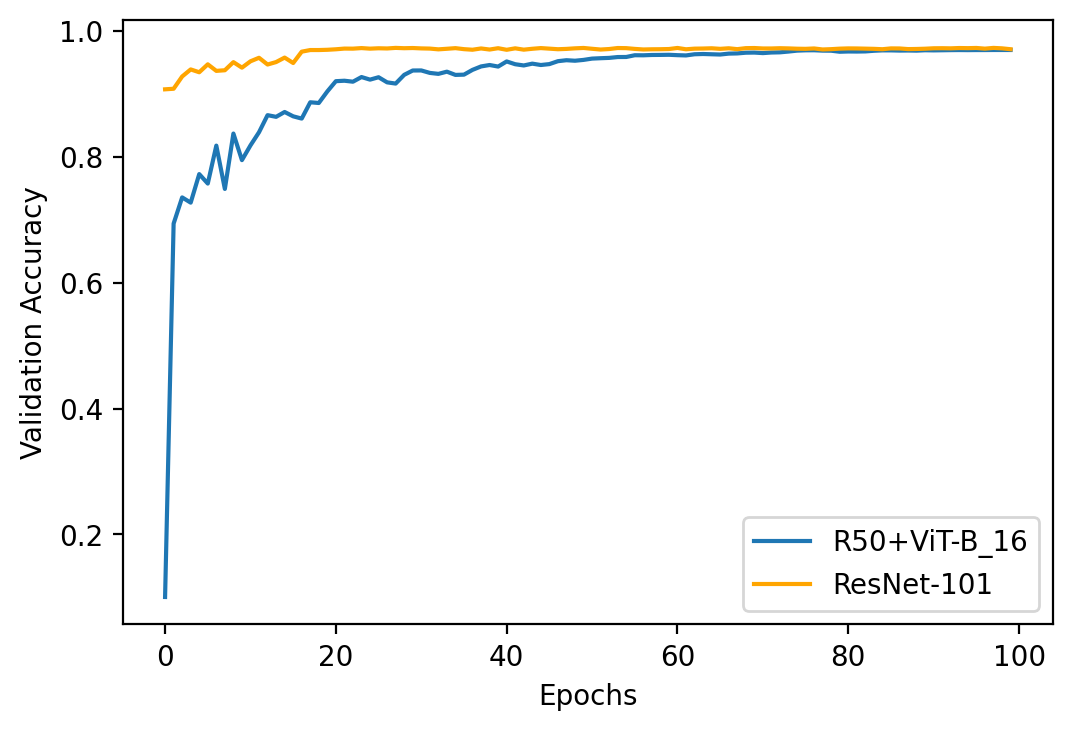

In [ ]:
plt.figure(figsize=(6,4), dpi = 200)
plt.plot(vit_my_acc, label = 'R50+ViT-B_16')
plt.plot(my_acc_1, label = 'ResNet-101', color = 'orange')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()